# Homework 5
#### Assigned: 2019-04-25
#### Due EOD: 2019-05-02

Based on Lecture 12
+ The student fills in the <...> fields.  
+ The student can create as many new cells as necessary in the solution sections.

**Make sure you have activated the correct python envorinment**

#### Name:  Mengheng Xue
#### NetID: mx586

## Problem 1 (20 points)

A CNN has the following structure:  

Conv2D_Layer -> Pooling_Layer -> Flattening_Layer -> Dense_Layer

+ input shape (size of the image): $M_1 \times M_2$
+ conv2d kernel with bias
+ conv2d kernel shape: $K_1 \times K_2$  
+ conv2d padding: same  
+ conv2d stride in both dimensions: 1  
+ conv2d filters (number of kernels): $F$
+ pooling layer size: $P_1 \times P_2$ (assume $P_{1,2}$ is a divisor of $M_{1,2}$) 
+ pooling padding: same
+ pooling stride in both dimensions: 1
+ flattening layer  
+ dense layer with bias
+ dense layer units (number of nodes): $H$

Write down the expression that gives the total number of parameters to be fitted $Q$ in terms of the above values.

## Solution 1

<...>

## Problem 2 (80 points) 

Use LSTM to analyze S&P 500 returns over the period 2004-2006.

The data file "stock-treasury-2004_2006.csv", to be found in the "Data" folder, contains the following:  
+ TREAS_3M: the yield of the 3-month treasury note in percent (i.e 2.1 means 2.1%)
+ Adjusted close price of ten major stocks: GM, F, UTX, CAT, MRK, PFE, IBM, MSFT, C, XOM
+ SP: The S&P 500 equity index level at the close of the trading day  

**Do the following:**  

Use the pandas read_csv function to read the Date and SP columns in a data frame called "sp_df".  
Rename the "SP" column into "ClosePx" in the same read_csv call.  
Compute the close-to-close index returns as:  $r_t = P_{t+1}/P_t - 1$ and add them as a new column "DailyRet".  
It is recommended to express all daily returns in basis points (10,000 bps = 100% = 1)

We want to train an RNN that looks back $M$ days and forecasts forward $N$ days.  
Therefore the RNN will use return sequences of size $M$, and targets of size $N$.  

Reformat the return data suitable for RNN processing as follows.  
From the "DailyRet" column of "sp_df", create a data input matrix $X$ containing rows as below:    
$$r_0, r_1, r_2, \ldots, r_{M-1}$$  
$$r_1, r_2, r_3, \ldots, r_{M}$$  
$$r_2, r_3, r_4, \ldots, r_{M+1}$$  
$$\ldots$$
From the "DailyRet" column of "sp_df", create also a target matrix $y$ containing rows as below:
$$ r_{M}, r_{M+1}, \ldots, r_{M+N-1}$$
$$ r_{M+1}, r_{M+2}, \ldots, r_{M+N}$$
$$ r_{M+2}, r_{M+3}, \ldots, r_{M+N+1}$$
$$\ldots$$

Set $M=16$ and $N=4$.  
Build an RNN with two LSTM cells and train it on the first 607 sequences.  
This means that the training set contains returns with the latest date of 2016-05-31.    
Use the remaining returns for out-of-sample testing.  
This is a regression task, so train the network using mean_squared_error loss.  
When connecting the two LSTMs, make sure you set the parameter return_sequences=True on the first LSTM, 
so that the second can see the sequences.

Compute the out-of-sample actual and predicted 2-day, 3-day, ..., N-day return, by summing 1-day forward returns up to this horizon.  
N-day return is the return from today's close to the close of the N-th day forward from today.  
Calculate and report the RMSE and the correlation between actual and predicted 1-day, 2-day, ..., N-day returns.  
Plot the actual and predicted returns in the out-of-sample part.  
What do you conclude regarding the quality of the forecasts?


## Solution 2

### data preprocessing

In [1]:
# import libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import the dataset  
dataset = pd.read_csv('stock-treasury-2004_2006.csv')
dataset.head()

,Date,TREAS_3M,GM,F,UTX,CAT,MRK,PFE,IBM,MSFT,C,XOM,SP
0,02-Jan-04,0.91,46.72,14.55,45.13,39.35,41.76,32.85,89.10,24.00,44.17,38.31,1108.48
1,05-Jan-04,0.90,47.55,15.02,45.40,40.42,42.60,33.73,90.56,24.60,44.88,39.20,1122.22
2,06-Jan-04,0.90,47.26,14.97,45.29,39.70,42.40,33.71,90.57,24.69,44.93,38.94,1123.67
3,07-Jan-04,0.89,47.91,15.38,45.43,39.27,42.45,34.00,90.30,24.66,44.99,38.65,1126.33
4,08-Jan-04,0.86,47.90,15.48,45.38,38.97,42.67,33.68,90.55,24.62,45.18,38.56,1131.92


In [2]:
sp_df = dataset.loc[:, ['Date', 'SP']] # create sp_df 
sp = sp_df.loc[:, 'SP'].values
dr = [(sp[i+1] / sp[i] -1)*10000 for i in range(len(sp)-1)]  # daily return calculation 
sp_df.drop(sp_df.index[0], inplace=True) # remove first row 
sp_df['DailyRet'] = dr
data_raw = sp_df.iloc[:, 2:3].values
sp_df.head(20)

,Date,SP,DailyRet
1,05-Jan-04,1122.22,123.953522
2,06-Jan-04,1123.67,12.920818
3,07-Jan-04,1126.33,23.672431
4,08-Jan-04,1131.92,49.630215
5,09-Jan-04,1121.86,-88.875539
6,12-Jan-04,1127.23,47.866935
7,13-Jan-04,1121.22,-53.316537
8,14-Jan-04,1130.52,82.945363
9,15-Jan-04,1132.05,13.533595
10,16-Jan-04,1139.83,68.724880


In [3]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(data_raw)

train_size = 607
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of entries (training set, test set): " + str((len(train), len(test))))

# function to create train and test set


def create_dataset(dataset, train_window_size=16, test_window_size=4):
    data_X, data_Y = [], []
    for i in range(len(dataset) - train_window_size-test_window_size + 1):
        a = dataset[i:(i + train_window_size), 0]
        b = dataset[(i+train_window_size):(i+train_window_size+test_window_size), 0]
        data_X.append(a)
        data_Y.append(b)
    return(np.array(data_X), np.array(data_Y))


train_X, train_y = create_dataset(train)
test_X, test_y = create_dataset(test)
print("Original training data shape:")
print(train_X.shape)
print(train_y.shape)

# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 1))
print("New training data shape:")
print(train_X.shape)


Number of entries (training set, test set): (607, 65)
Original training data shape:
(588, 16)
(588, 4)
New training data shape:
(588, 16, 1)


### build LSTM

In [4]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import math

Using TensorFlow backend.


In [5]:
def build_model(window_size = 16):
    model = Sequential() 
    model.add(LSTM(input_shape = (window_size, 1), units=50, return_sequences = True, activation='relu')) # add first LSTM layer 
    model.add(Dropout(0.2))# dropout regulization to avoid overfitting
    model.add(LSTM(input_shape=(window_size, 1), units=50, return_sequences = False, activation='relu')) # add second LSTM layer 
    model.add(Dropout(0.2))
#     model.add(Dense(units = 50, kernel_initializer = 'uniform', activation = 'relu', input_dim = 80))
#     model.add(Dropout(0.2))
    model.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'linear'))
    model.summary()
    return(model)

model = build_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 16, 50)            10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 204       
Total params: 30,804
Trainable params: 30,804
Non-trainable params: 0
_________________________________________________________________


In [6]:
# compile, fit and evaluate
def fit_model(model, train_X, train_y):
    model.compile(loss='mean_squared_error', optimizer='RMSprop', metrics=['mean_absolute_error']) 
    es = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, mode='auto', baseline=None)
    model.fit( train_X, train_y, batch_size=50, epochs=100, validation_split=0.1, callbacks=[es], verbose=1)
    return model
    
model_fit = fit_model(model, train_X, train_y)    

# pred = scaler.inverse_transform(model.predict(test_X))
# pred[:, 0]

Train on 529 samples, validate on 59 samples
Epoch 1/100
529/529 [==============================] - 2s 3ms/step - loss: 0.1730 - mean_absolute_error: 0.3698 - val_loss: 0.0425 - val_mean_absolute_error: 0.1675
Epoch 2/100
529/529 [==============================] - 0s 334us/step - loss: 0.0381 - mean_absolute_error: 0.1557 - val_loss: 0.0266 - val_mean_absolute_error: 0.1252
Epoch 3/100
529/529 [==============================] - 0s 342us/step - loss: 0.0354 - mean_absolute_error: 0.1486 - val_loss: 0.0274 - val_mean_absolute_error: 0.1241
Epoch 4/100
529/529 [==============================] - 0s 363us/step - loss: 0.0369 - mean_absolute_error: 0.1527 - val_loss: 0.0269 - val_mean_absolute_error: 0.1258
Epoch 5/100
529/529 [==============================] - 0s 344us/step - loss: 0.0356 - mean_absolute_error: 0.1489 - val_loss: 0.0287 - val_mean_absolute_error: 0.1276


In [7]:
def predit_model(model_fit, test_X, test_y):
    pred = scaler.inverse_transform(model_fit.predict(test_X))
    actual = scaler.inverse_transform((test_y))
    return pred, actual 

pred, actual = predit_model(model_fit, test_X, test_y)

# function obtain n-day return 
def nday_return(return_data, n):
    nday_return = return_data[:,0]
    if (n==0):
        return nday_return
    else:
        for i in range(1,n+1):
            nday_return = nday_return + return_data[:, i]
        return nday_return 
    
    
oneday_pred_return = nday_return(pred, 0)
twoday_pred_return = nday_return(pred, 1)
threeday_pred_return = nday_return(pred, 2)
fourday_pred_return = nday_return(pred, 3)
oneday_act_return  = nday_return(actual, 0)
twoday_act_return  = nday_return(actual, 1)
threeday_act_return  = nday_return(actual, 2)
fourday_act_return  = nday_return(actual, 3)

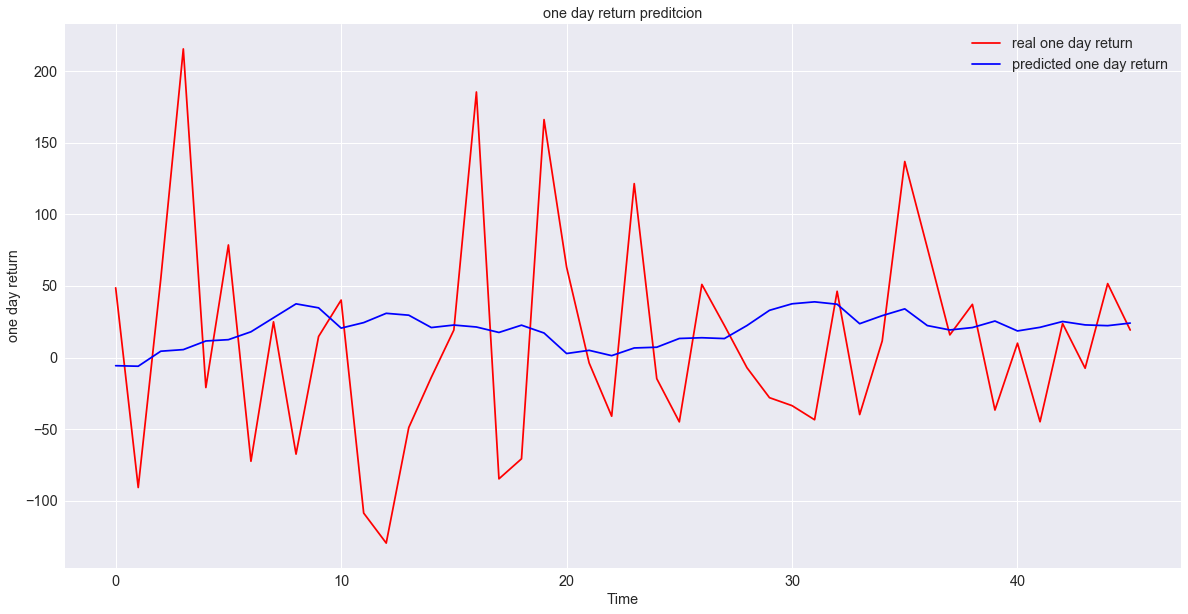

In [8]:
# Create the plot.
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['legend.fontsize'] = 'x-large'
plt.rcParams['axes.labelsize'] = 'x-large'
plt.rcParams['axes.titlesize'] = 'x-large'
plt.rcParams['xtick.labelsize'] = 'x-large'
plt.rcParams['ytick.labelsize'] = 'x-large'


# Visualising 1-day return 
plt.plot(oneday_act_return, color = 'red', label = 'real one day return')
plt.plot(oneday_pred_return, color = 'blue', label = 'predicted one day return')
plt.title('one day return preditcion')
plt.xlabel('Time')
plt.ylabel('one day return')
plt.legend()
plt.show()

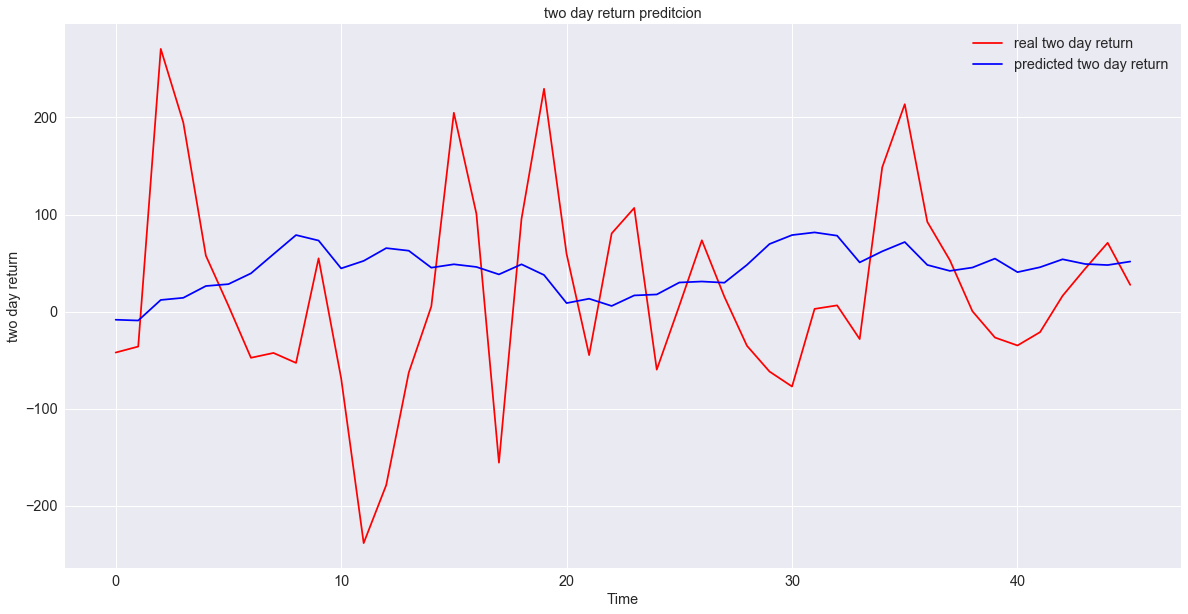

In [9]:
# Visualising 2-day return 
plt.plot(twoday_act_return, color = 'red', label = 'real two day return')
plt.plot(twoday_pred_return, color = 'blue', label = 'predicted two day return')
plt.title('two day return preditcion')
plt.xlabel('Time')
plt.ylabel('two day return')
plt.legend()
plt.show()

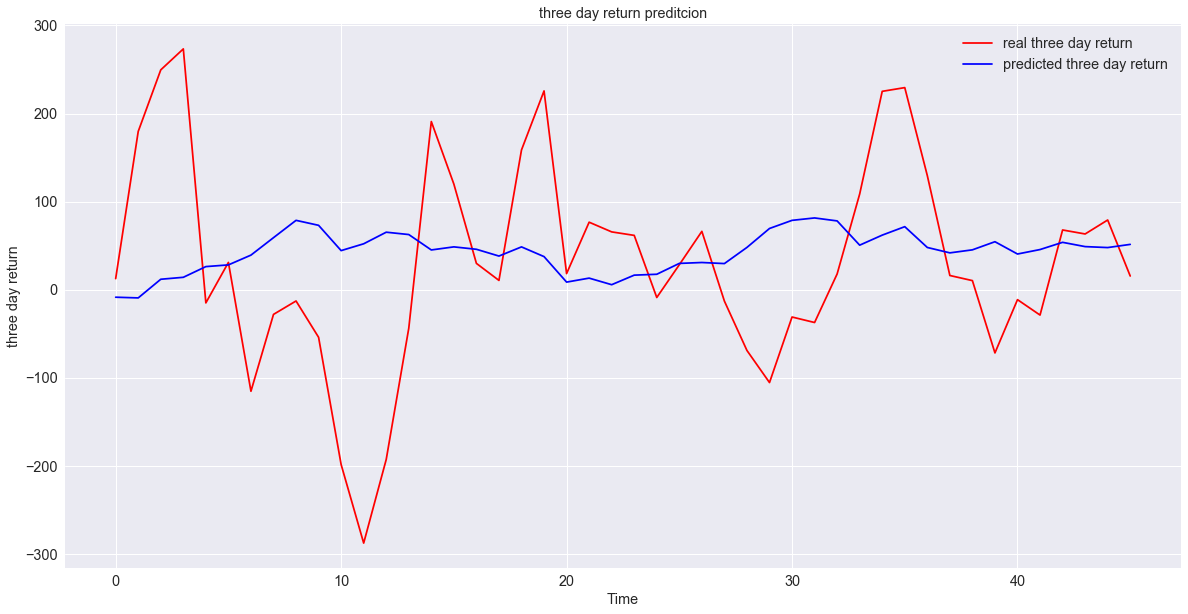

In [10]:
# Visualising 3-day return 
plt.plot(threeday_act_return, color = 'red', label = 'real three day return')
plt.plot(twoday_pred_return, color = 'blue', label = 'predicted three day return')
plt.title('three day return preditcion')
plt.xlabel('Time')
plt.ylabel('three day return')
plt.legend()
plt.show()

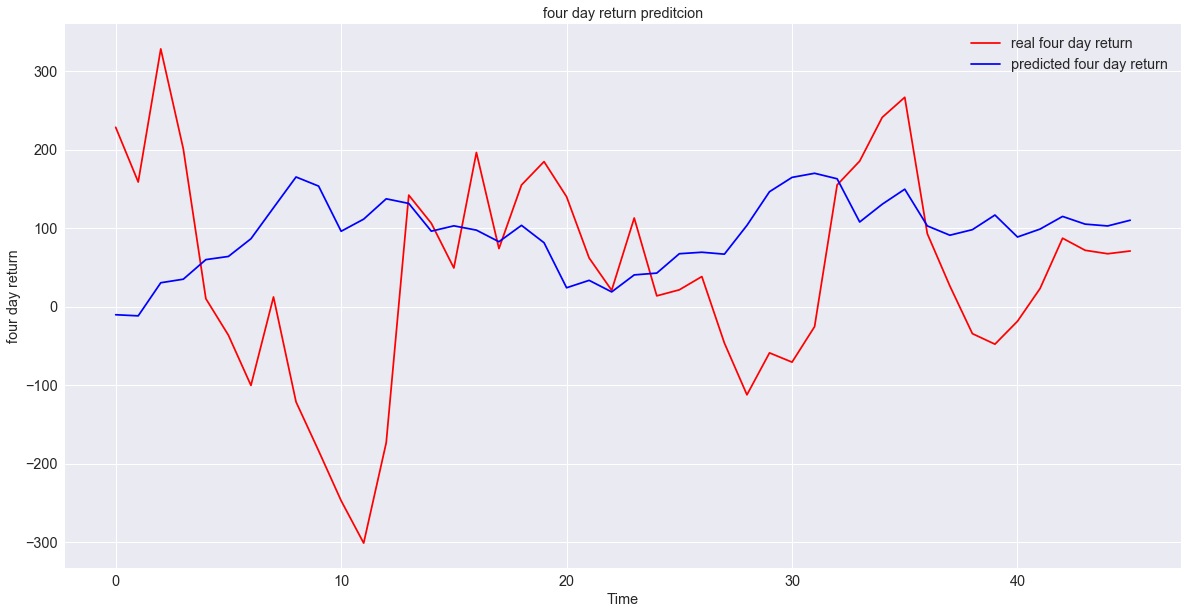

In [11]:
# Visualising 4-day return
plt.plot(fourday_act_return, color = 'red', label = 'real four day return')
plt.plot(fourday_pred_return, color = 'blue', label = 'predicted four day return')
plt.title('four day return preditcion')
plt.xlabel('Time')
plt.ylabel('four day return')
plt.legend()
plt.show()

In [ ]:
def predict_and_score(model, X, Y):
    # Make predictions on the original scale of the data.
    pred = scaler.inverse_transform(model.predict(X))
    # Prepare Y data to also be on the original scale for interpretability.
    orig_data = scaler.inverse_transform((Y))
    # Calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

rmse_train, train_predict = predict_and_score(model_fit, train_X, train_y)
# rmse_test, test_predict = predict_and_score(model_fit, test_X, test_y)

# print("Training data score: %.2f RMSE" % rmse_train)
# print("Test data score: %.2f RMSE" % rmse_test)